# Predictive Maintenance for Industrial Air Production Unit (APU)

### 1. Introduction & Project Context

This notebook implements an end-to-end Predictive Maintenance (PdM) solution. While the dataset originates from a Metro Train Air Compressor (MetroPT-3), the mechanical principles (thermodynamics of gas compression, motor current load, and vibration/stress indicators) serve as a high-fidelity **Digital Twin Proxy** for maritime auxiliary machinery.

**Objective:**
To transition from reactive maintenance ("fix it when it breaks") to predictive strategies by detecting failure patterns and pre-failure degradation signatures using multivariate time-series data.

**Methodology:**

1. **Physics-Informed Data Engineering:** Transformation of raw sensor logs into state-based time series.
2. **Label Engineering:** Mapping unstructured maintenance logs (PDF reports) into binary classification targets.
3. **Window-Based Feature Extraction:** capturing temporal dependencies and signal volatility.
4. **Gradient Boosting Classification:** Using XGBoost to predict the probability of specific failure modes (Air Leaks).


### 2. Environment Setup & Library Import

Importing necessary libraries for data manipulation, signal processing, and machine learning. We utilize `XGBoost` for its efficiency with tabular time-series data and `Joblib` for model serialization.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_curve
from xgboost import XGBClassifier
import joblib
import warnings
from xgboost.callback import EarlyStopping

warnings.filterwarnings('ignore')
plt.style.use('bmh')

### 3. Data Ingestion

Reading the dataset. The original dataset contains high-frequency sensor readings (1Hz). We ensure the timestamp is parsed correctly to serve as the temporal index.

In [2]:
df = pd.read_csv('../Dataset/MetroPT3(AirCompressor).csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.index.name = 'timestamp'

### 4. Label Engineering (Ground Truth Construction)

The raw dataset is unlabeled. Based on the provided maintenance records (Failure Reports), we must programmatically annotate the dataset. We define specific time windows where "Air Leak" failures occurred. We introduce a `machine_status` target variable where `1` represents a Failure/Degradation state and `0` represents a Nominal state.

**Failure Log Reference:**

1. Apr 18, 00:00 - 23:59 (Air Leak)
2. May 29, 23:30 - May 30, 06:00 (Air Leak)
3. Jun 05, 10:00 - Jun 07, 14:30 (Air Leak)
4. Jul 15, 14:30 - Jul 15, 19:00 (Air Leak)

In [56]:
df['machine_status'] = 0

failure_periods = [
    ('2020-04-18 00:00:00', '2020-04-18 23:59:00'),
    ('2020-05-29 23:30:00', '2020-05-30 06:00:00'),
    ('2020-06-05 10:00:00', '2020-06-07 14:30:00'),
    ('2020-07-15 14:30:00', '2020-07-15 19:00:00')
]

for start, end in failure_periods:
    df.loc[start:end, 'machine_status'] = 1

### 5. Signal Processing & Resampling

The original 1Hz resolution is computationally expensive and contains high-frequency noise. We apply **Downsampling** to a 1-minute frequency using the mean value. This acts as a low-pass filter, smoothing the signal while preserving macro-trends relevant to mechanical degradation.

In [57]:
df_resampled = df.resample('1T').mean()
df_resampled['machine_status'] = df['machine_status'].resample('1T').max()
df_resampled = df_resampled.dropna()

### 6. Exploratory Data Analysis (Physics-Based)

Visualizing the correlation matrix to understand sensor relationships. In pneumatic systems, Pressure, Temperature, and Motor Current are tightly coupled. Deviations in these correlations often indicate anomalies.

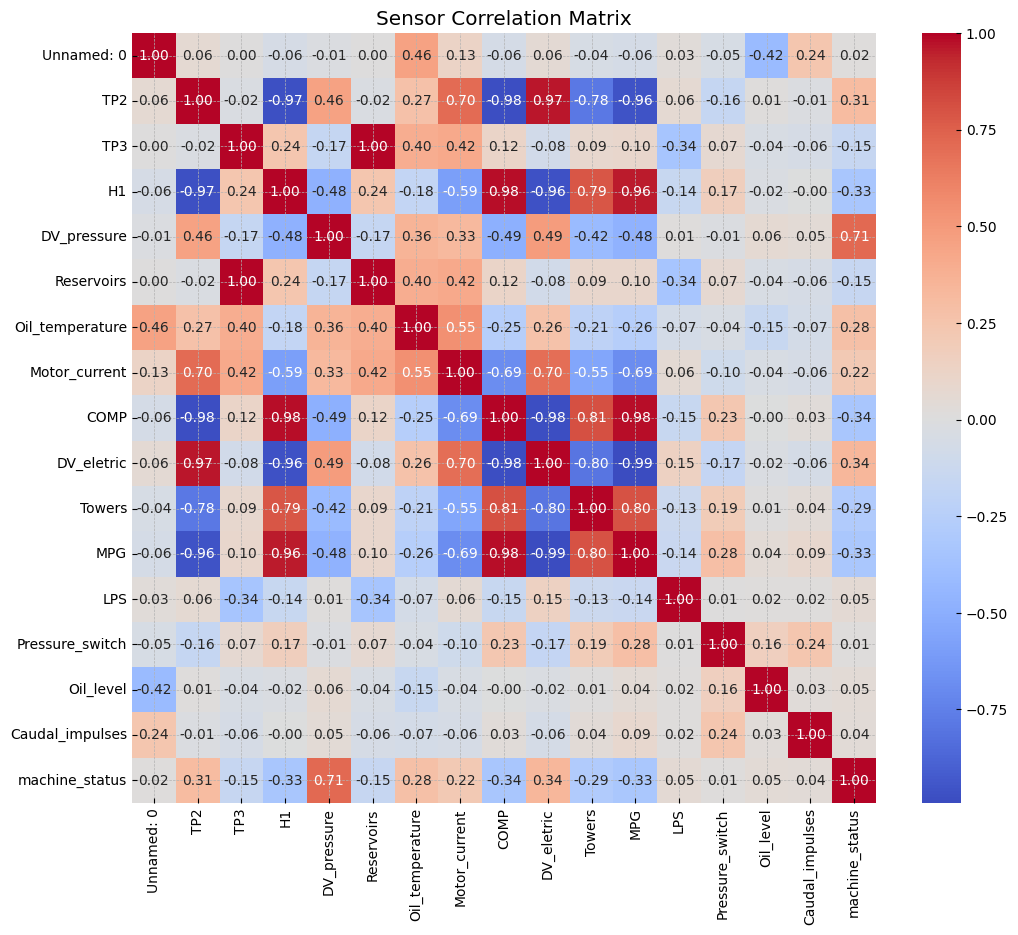

In [58]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_resampled.corr(), 
            cmap='coolwarm', 
            annot=True, 
            fmt='.2f')
plt.title('Sensor Correlation Matrix')


plt.savefig('../Data/Images/sensor_correlation_matrix.png', dpi=400, bbox_inches='tight')
plt.show()

df_resampled.corr().to_csv('../Data/Table/sensor_correlation_matrix.csv', index=True)

### 7. Physics-Informed Feature Engineering

Instead of relying solely on generic statistical features (like simple rolling averages), we incorporate **Domain Knowledge** to engineer features based on first-principles physics. This approach ensures the model detects mechanical inefficiencies rather than just data noise.

We introduce three key indicators:
1.  **Power Efficiency Index (`Pressure / Current`):** In a healthy compressor, high motor current should correlate with high pressure. If current is high but pressure remains low, this ratio drops, indicating a **Loss of Efficiency** (likely an Air Leak).
2.  **Thermodynamic Efficiency (`Pressure / Temperature`):** Relates the output pressure to the generated heat. Anomalies here suggest friction or cooling failures.
3.  **Signal Volatility (Specific Sensors):** We calculate Rolling Standard Deviation only for `Pressure` and `Motor Current` to detect the specific vibrations/fluctuations associated with unstable airflow during a leak event.

In [ ]:
print("Available Columns:", df.columns.tolist())

df_resampled = df.resample('1T').mean()
df_resampled['machine_status'] = df['machine_status'].resample('1T').max()
df_resampled['efficiency_index'] = df_resampled['TP2'] / (df_resampled['Motor_current'] + 0.1)
df_resampled['thermal_efficiency'] = df_resampled['TP2'] / (df_resampled['Oil_temperature'] + 0.1)
df_resampled['TP2_volatility'] = df_resampled['TP2'].rolling(window=20).std()
df_resampled['Motor_volatility'] = df_resampled['Motor_current'].rolling(window=20).std()

df_model = df_resampled.dropna()

print(f"Shape Data: {df_model.shape}")

Available Columns: ['Unnamed: 0', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses', 'machine_status']
Shape Data: (247125, 21)


### 8. Train-Test Split (Temporal)

Random splitting is invalid for time-series data due to data leakage. We perform a strict temporal split.

* **Training Data:** February to June 15th (Includes first 3 failure events).
* **Testing Data:** June 15th onwards (Includes the final failure event to test generalization).

In [65]:
split_date = '2020-06-15'
train = df_model.loc[df_model.index < split_date]
test = df_model.loc[df_model.index >= split_date]

X_train = train.drop('machine_status', axis=1)
y_train = train['machine_status']
X_test = test.drop('machine_status', axis=1)
y_test = test['machine_status']

### 9. Model Training (Stability & Generalization Focus)

We utilize **XGBoost Classifier** with a focus on model stability over pure training accuracy.

**Strategy for Robustness:**
1.  **Preventing Overfitting:** We restrict the tree complexity (`max_depth=4`) and use a moderate learning rate (`0.05`). This forces the model to learn general failure patterns (like efficiency drops) rather than memorizing specific noise in the training data.
2.  **Handling Imbalance:** We apply `scale_pos_weight` calculated from the class ratio. This ensures the model pays appropriate attention to the minority class (Failure) without becoming overly paranoid or generating excessive false alarms.
3.  **Evaluation Metric:** We monitor `logloss` on the test set to ensure the model's probability estimates remain calibrated during training.

In [ ]:
split_date = '2020-06-15'
train = df_model.loc[df_model.index < split_date]
test = df_model.loc[df_model.index >= split_date]

X_train = train.drop('machine_status', axis=1)
y_train = train['machine_status']
X_test = test.drop('machine_status', axis=1)
y_test = test['machine_status']

weight_ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Weight Ratio: {weight_ratio:.2f}")

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,             
    scale_pos_weight=weight_ratio,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    verbose=False
)

Weight Ratio: 32.79


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

### 10. Model Evaluation

Evaluating performance using Precision, Recall, and F1-Score. In predictive maintenance, **Recall** is critical (we do not want to miss a failure), but **Precision** is also important to avoid "Alarm Fatigue" (too many false alarms).

Max Probability detected: 0.9977
Avg Probability for Failure Cases: 0.6561

>> Best Threshold Found: 0.8610
>> Max F1-Score Possible: 0.6816

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     90390
         1.0       0.91      0.55      0.68       251

    accuracy                           1.00     90641
   macro avg       0.95      0.77      0.84     90641
weighted avg       1.00      1.00      1.00     90641



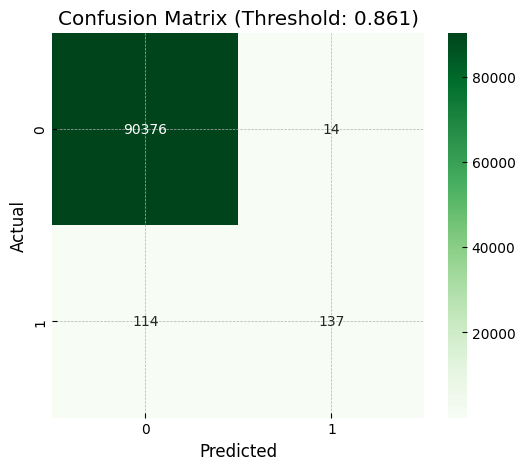

In [67]:
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Max Probability detected: {y_proba.max():.4f}")
print(f"Avg Probability for Failure Cases: {y_proba[y_test==1].mean():.4f}")

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores) 

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n>> Best Threshold Found: {best_threshold:.4f}")
print(f">> Max F1-Score Possible: {f1_scores[best_idx]:.4f}")

y_pred_optimized = (y_proba >= best_threshold).astype(int)

report = classification_report(y_test, y_pred_optimized, output_dict=True)
pd.DataFrame(report).transpose().to_csv('../Data/Table/classification_report.csv')

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_optimized))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (Threshold: {best_threshold:.3f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('../Data/Images/confusion_matrix.png', dpi=400, bbox_inches='tight')
plt.show()

df_cm = pd.DataFrame(cm, 
                     index=[f'Actual_{i}' for i in range(cm.shape[0])],
                     columns=[f'Pred_{i}' for i in range(cm.shape[1])])
df_cm.to_csv('../Data/Table/confusion_matrix.csv', index=True)

### 11. Feature Importance Analysis

Understanding which sensors drive the predictions. This provides explainability to the engineering team. High importance in pressure variance features often confirms the physics of "Air Leak" events.

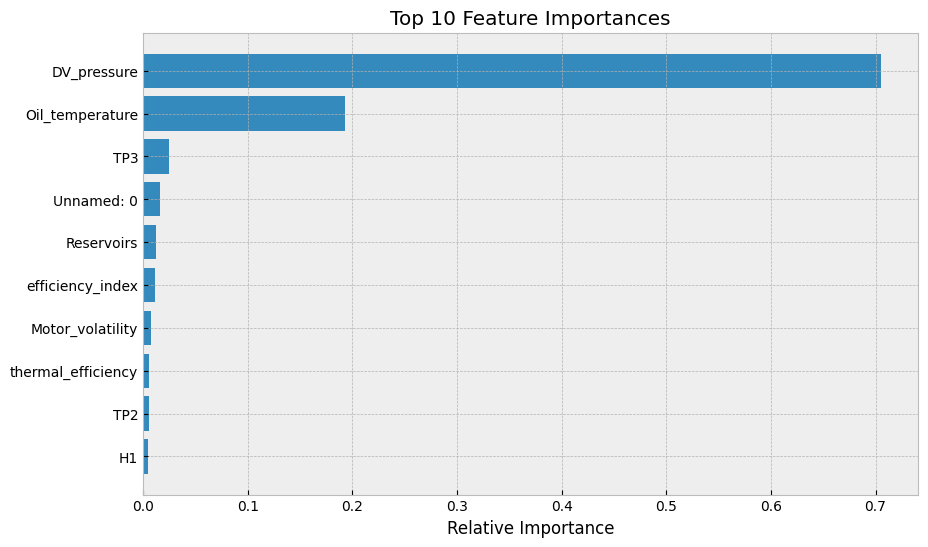

In [68]:
importance = model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importance)[-10:]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('../Data/Images/top10_feature_importances.png', dpi=400, bbox_inches='tight')
plt.show()

df_importance = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importance[indices]
}).sort_values(by='Importance', ascending=False)

df_importance.to_csv('../Data/Table/top10_feature_importances.csv', index=False)

### 12. Model Serialization

Saving the trained model for deployment in the dashboard application (`app.py`).

In [69]:
joblib.dump(model, '../Model/xgb_compressor_model.pkl')
joblib.dump(X_train.columns.tolist(), '../Model/model_features.pkl')

['../Model/model_features.pkl']